# Overall Process

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_PATH = "d3_ecoli/img_05.jpg"

## 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [23]:
# Read and resize the image
img = cv.imread(IMAGE_PATH)
img = cv.resize(img, None, fx=0.5, fy=0.5)

# Convert the image to LAB color space
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

# Create CLAHE object
clahe = cv.createCLAHE()

# Apply CLAHE to the L (lightness) channel
lab[:,:,0] = clahe.apply(lab[:,:,0])

# Convert LAB image and GRAY image back to BGR color space
bgr = cv.cvtColor(lab, cv.COLOR_LAB2BGR)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

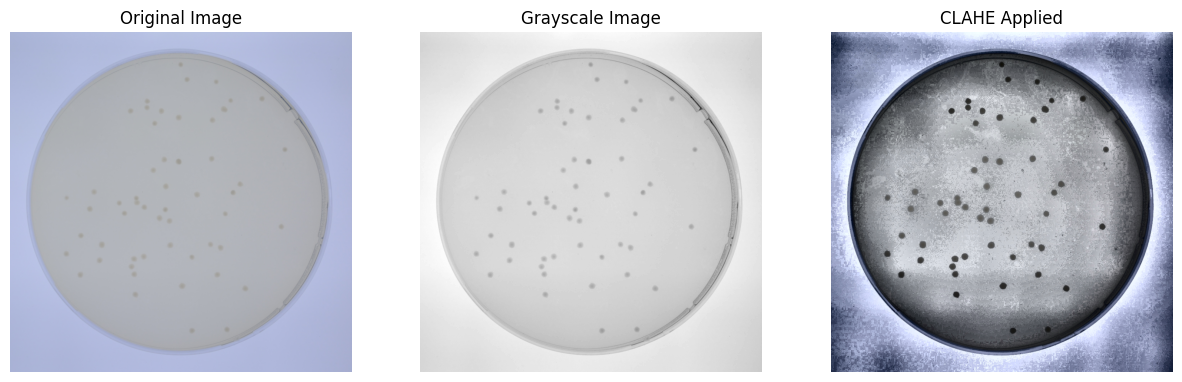

In [24]:
# Prepare images for display
images = [img, gray, bgr]
titles = ['Original Image', 'Grayscale Image', 'CLAHE Applied']

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if len(images[i].shape) == 2:  # grayscale image
        plt.imshow(images[i], cmap='gray')
    else:  # color image
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis('off')

plt.show()

## 3. WATERSHED Algorithm

The objective of the Watershed algorithm to perform image segmentation on a given image using the watershed algorithm. The segmentation process aims to identify distinct objects or regions within the image. By labeling sure foreground and background regions and differentiating unknown areas, the watershed algorithm can effectively segment the image into distinct regions. In this case: the outter region of the petri dish and the borders.

1. **First processing of the image**
   - Load the image from the specified file path and resize it
   - Convert it into grascale for further processing
<br><br>

2. **Thresholding Operation**
   - Apply a binary inverse threshold to the grayscale image.
   - Pixels with intensity lower than the threshold defined are set to 0 (black) and 1 (white) otherwise.
<br><br>


3. **Morphological Opening Operation**
   - Perform morphological opening using a 3x3 kernel to remove small noise from the binary image.
<br><br>


4. **Dilation Operation to get Background**
   - Dilate the result of the morphological opening to ensure that the background regions are well-defined and connected.
<br><br>

5. **Distance Transform and Thresholding Operations to Get Sure Foreground**
   - Compute the distance transform of the morphologically processed image.
   - The distance transform computes the distance of each pixel to the nearest zero pixel (background) and then apply the threshold.
<br><br>

6. **Identifying Unknown Regions**
   - Subtract the sure foreground from the sure background to identify the unknown regions.
<br><br>

7. **Marker Labelling**
   - Label the connected components in the sure foreground image.
   - Increment all labels by one to ensure the background is labeled as 1.
   - Mark the unknown regions with zero to distinguish them from known regions.
<br><br>

8. **Applying the Watershed Algorithm**
   - Apply the watershed algorithm to segment the image based on the markers.
   - The watershed algorithm treats the pixel values as elevations in a topographic surface and finds the watershed lines that separate different regions.
   - Mark the boundaries of the segmented regions in red.


In [9]:
img = cv2.imread(IMAGE_PATH)
img = cv2.resize(img, None, fx=0.35, fy=0.35)

# Converts the image from BGR color space to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a binary inverse thresholding
# Pixels greater than 135 are set to 0. Otherwise, 255.
ret, thresh = cv2.threshold(gray, 135, 255, cv2.THRESH_BINARY_INV)

# Morphological opening on the threshold image to remove noise
# Open operation is composed of erosion and then dilation.
kernel = np.ones((3,3), np.uint8)
notNoise = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Dilate to ensure that the background regions are well defined
sure_bg = cv2.dilate(notNoise, kernel, iterations=3)

# Distance transform and threshold to get sure foreground
dist_transform = cv2.distanceTransform(notNoise, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
# Markers help to determine which pixels belong to which segment in the image
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers += 1

# Mark the region of unknown with zero
markers[unknown == 255] = 0

# Apply watershed algorithm
markers = cv2.watershed(img, markers)

# Boundaries of segmented regions in red.
img[markers == -1] = [255, 0, 0]

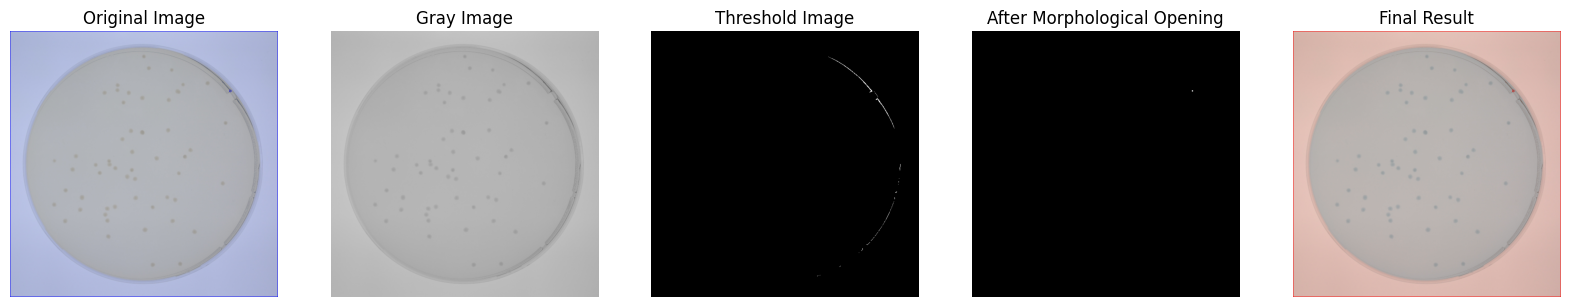

In [17]:
# Convert the images to RGB for displaying
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
notNoise_rgb = cv2.cvtColor(notNoise, cv2.COLOR_GRAY2RGB)
sure_bg_rgb = cv2.cvtColor(sure_bg, cv2.COLOR_GRAY2RGB)
sure_fg_rgb = cv2.cvtColor(sure_fg, cv2.COLOR_GRAY2RGB)
unknown_rgb = cv2.cvtColor(unknown, cv2.COLOR_GRAY2RGB)


fig, axs = plt.subplots(1, 5, figsize=(20, 10))

axs[0].imshow(img_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(gray_rgb)
axs[1].set_title('Gray Image')
axs[1].axis('off')

axs[2].imshow(thresh_rgb)
axs[2].set_title('Threshold Image')
axs[2].axis('off')

axs[3].imshow(notNoise_rgb)
axs[3].set_title('After Morphological Opening')
axs[3].axis('off')

axs[4].imshow(img)
axs[4].set_title('Final Result')
axs[4].axis('off')

plt.show()